In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.semi_supervised import LabelPropagation
from qns3vm.qns3vm import QN_S3VM

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

In [2]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Data Loading

In [3]:
# read data
feats = "Cap-shape, Cap-surface, Cap-color, Bruises, Odor, Gill-attachment, Gill-spacing, Gill-size, Gill-color, Stalk-shape, Stalk-root, Stalk-surface-above-ring, Stalk-surface-below-ring, Stalk-color-above-ring, Stalk-color-below-ring, Veil-type, Veil-color, Ring-number, Ring-type, Spore-print-color, Population, Habitat, Class"
cols = [x.strip() for x in feats.split(',')]
df = pd.read_csv('mushroom.csv',header=None, names=cols)
print(df.shape)
print(df.info())

# split dataset
X, X_test, y, y_test = train_test_split(df.iloc[:,:-1], df['Class'], test_size=0.2, random_state=1)

# split for pre-training
X_train, X_pre, y_train, y_pre = train_test_split(X,y,test_size=0.2,random_state=0)

# unlabel data, convert to SSL dataset
X_pre_l, X_pre_u, y_pre_l, _ = train_test_split(X_pre,y_pre,test_size=0.7,random_state=1)

df.head()

(8124, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Cap-shape                 8124 non-null   object
 1   Cap-surface               8124 non-null   object
 2   Cap-color                 8124 non-null   object
 3   Bruises                   8124 non-null   object
 4   Odor                      8124 non-null   object
 5   Gill-attachment           8124 non-null   object
 6   Gill-spacing              8124 non-null   object
 7   Gill-size                 8124 non-null   object
 8   Gill-color                8124 non-null   object
 9   Stalk-shape               8124 non-null   object
 10  Stalk-root                8124 non-null   object
 11  Stalk-surface-above-ring  8124 non-null   object
 12  Stalk-surface-below-ring  8124 non-null   object
 13  Stalk-color-above-ring    8124 non-null   object
 14  Stalk-color-b

,Cap-shape,Cap-surface,Cap-color,Bruises,Odor,Gill-attachment,Gill-spacing,Gill-size,Gill-color,Stalk-shape,...,Stalk-color-above-ring,Stalk-color-below-ring,Veil-type,Veil-color,Ring-number,Ring-type,Spore-print-color,Population,Habitat,Class
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e


# EDA

### Class Balance

In [4]:
# compute the percentage of each class
print(y_pre_l.value_counts()/len(y_pre_l))

e    0.533333
p    0.466667
Name: Class, dtype: float64


### Categorical Features Distributions

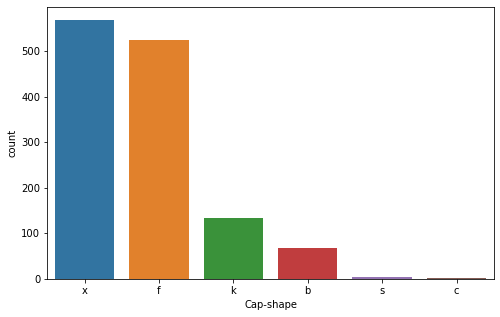

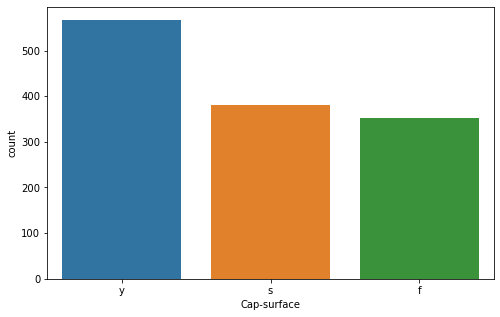

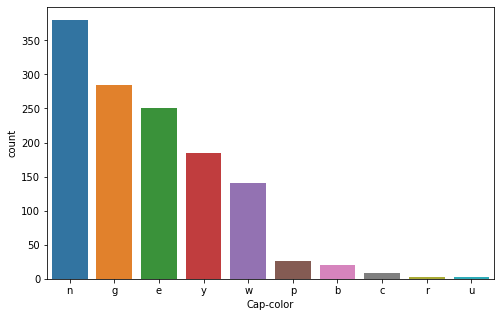

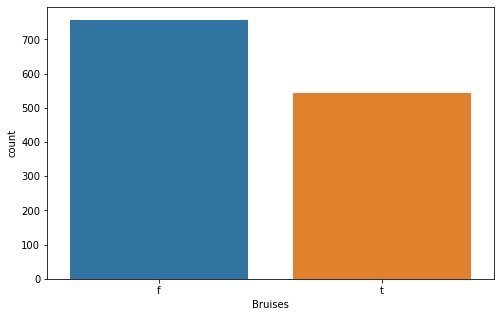

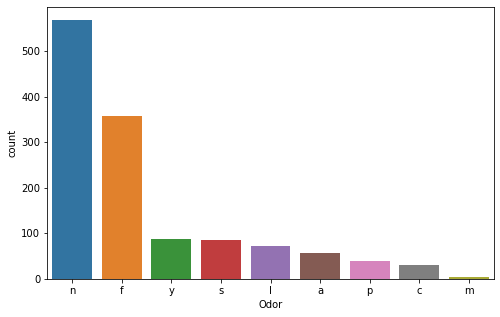

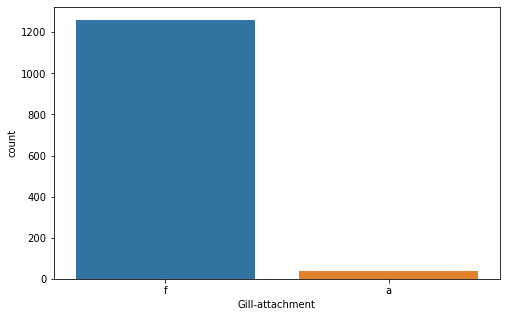

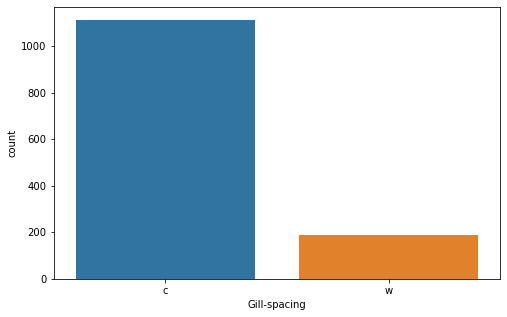

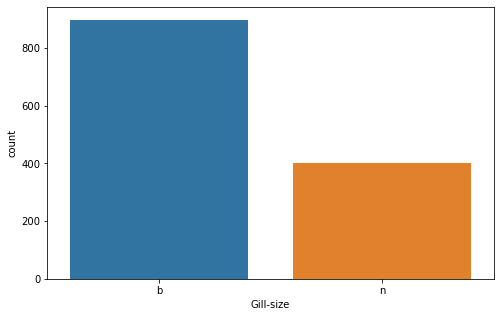

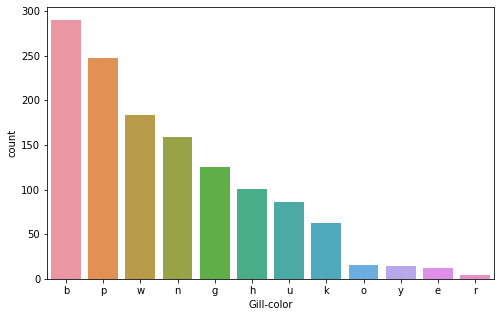

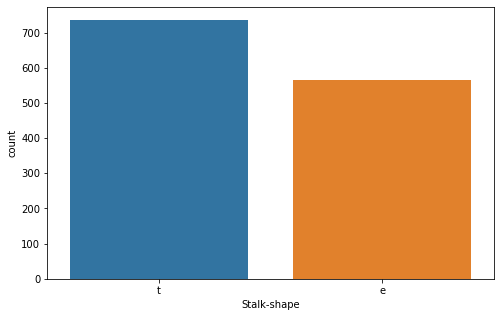

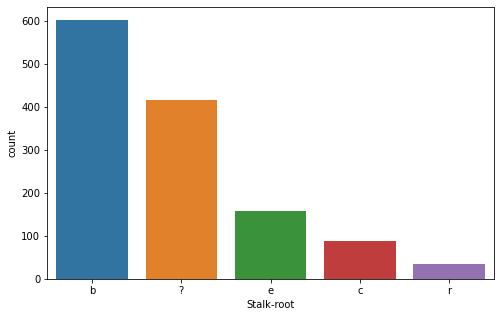

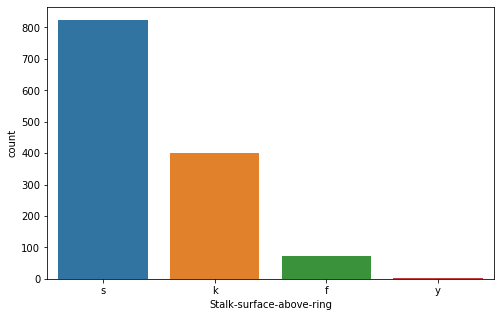

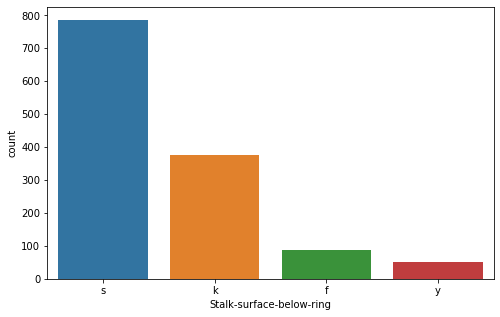

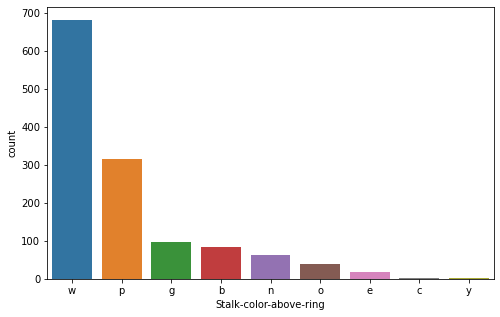

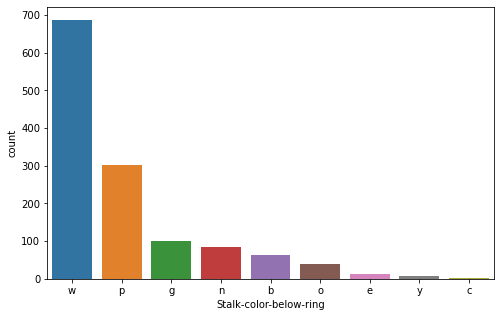

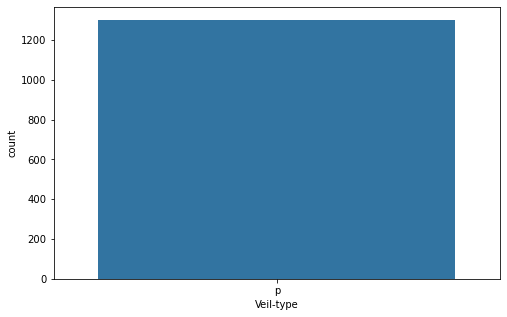

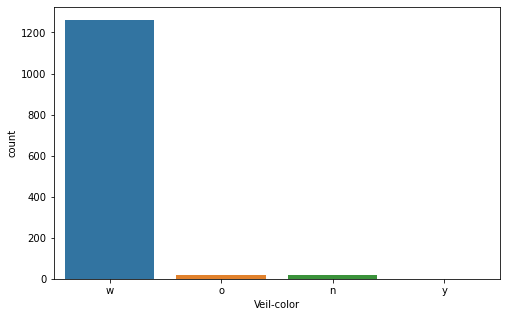

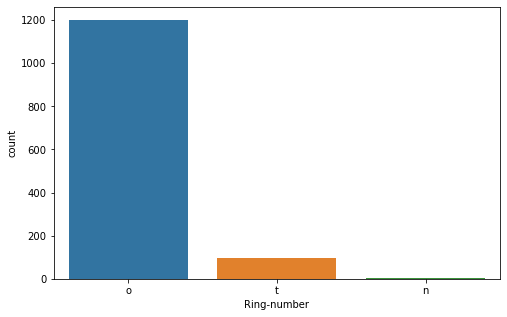

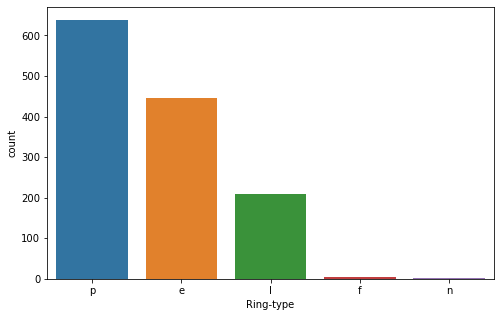

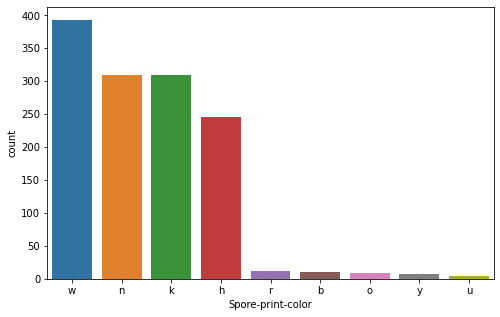

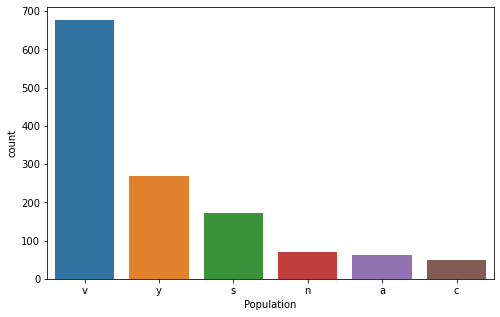

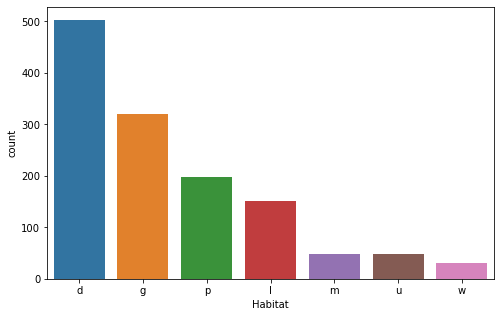

In [5]:
# show distributions for each attributes
for c in cols[:-1]:
    plt.figure(figsize=(8,5))
    sns.countplot(data=X_pre,x=c,order=X_pre[c].value_counts().index)
    plt.show()

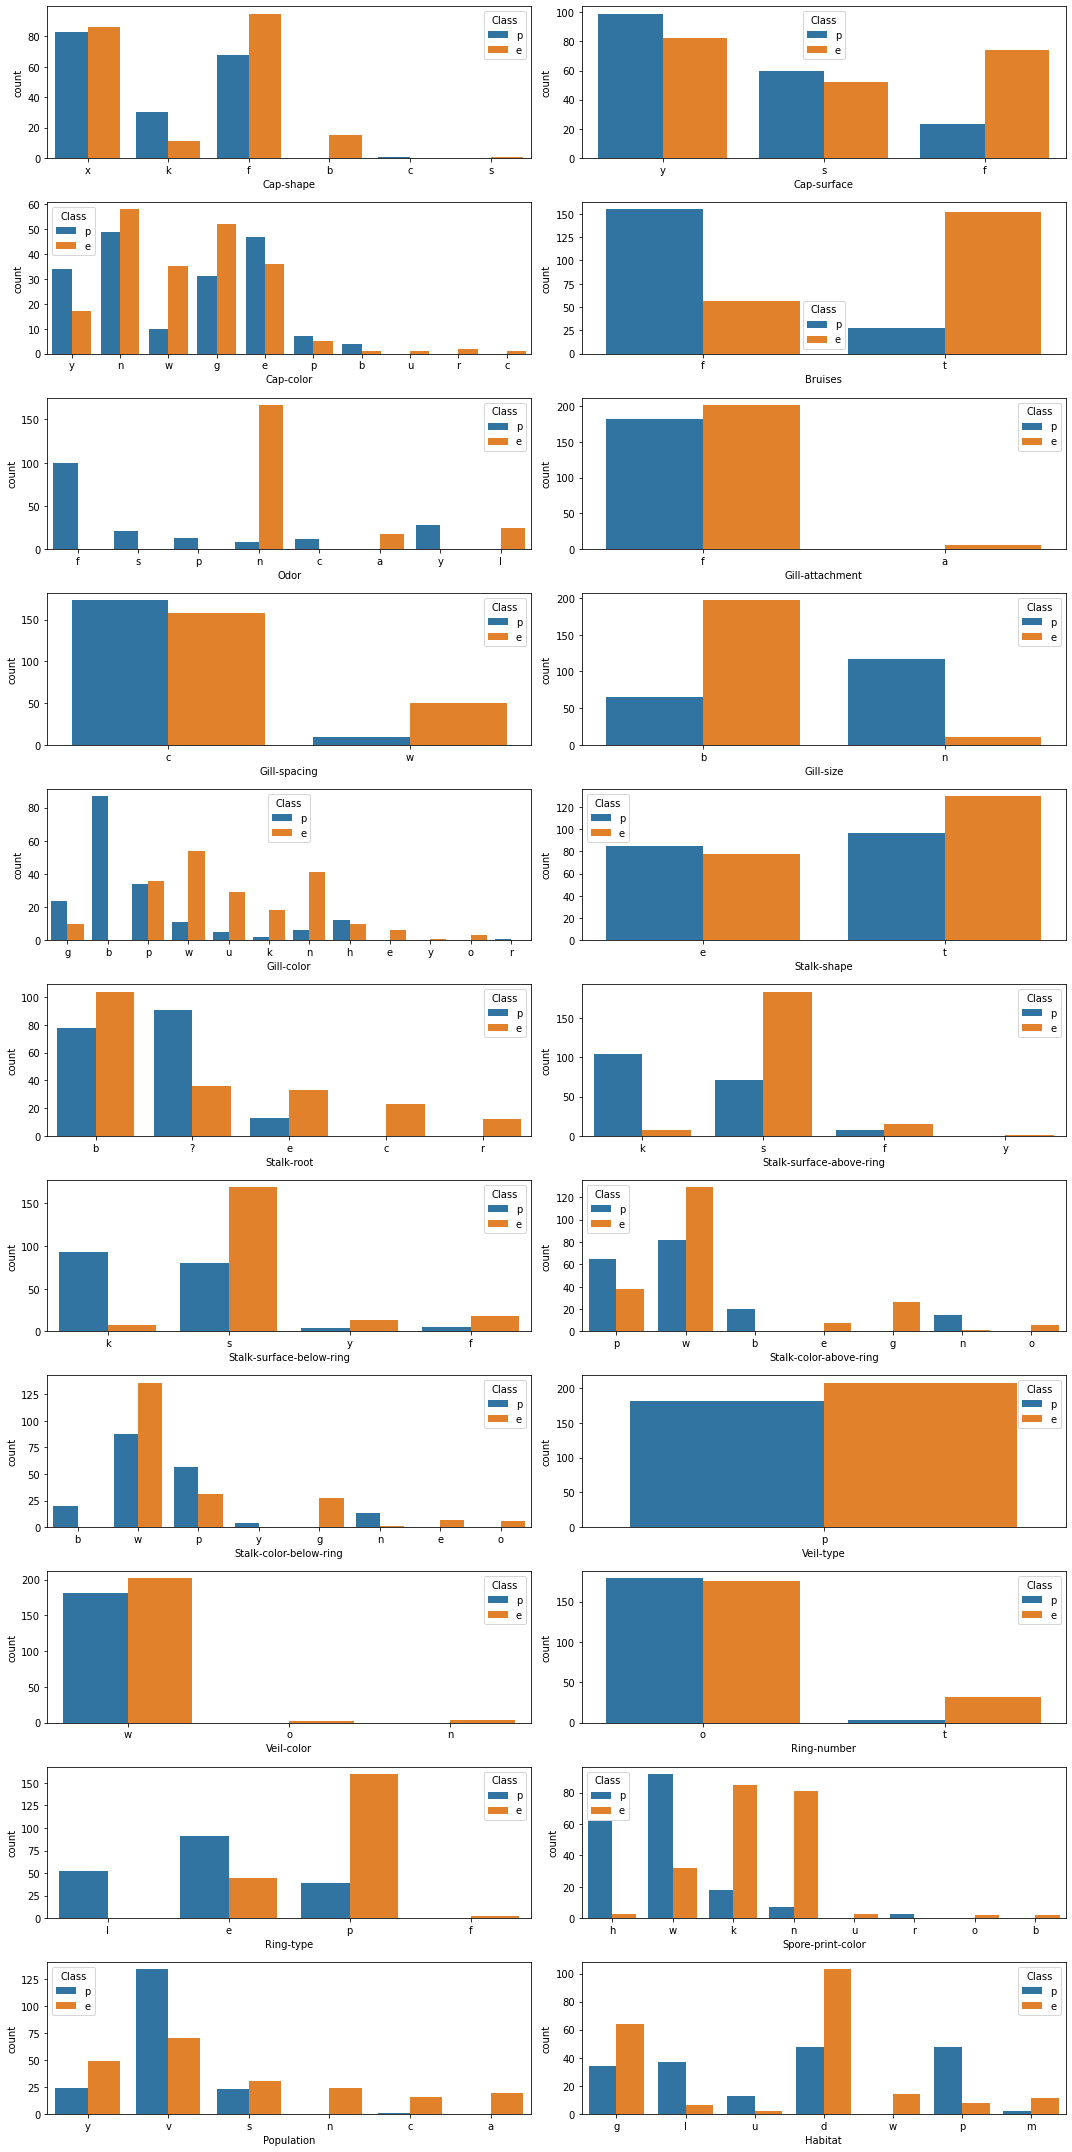

In [6]:
# show feature dists. by labels
fig, axs = plt.subplots(11,2,figsize=(15,30))

for i in np.arange(0,22,2):
    sns.countplot(data=X_pre_l,x=cols[i],hue=y_pre_l,ax=axs[i//2][0])
    sns.countplot(data=X_pre_l,x=cols[i+1],hue=y_pre_l,ax=axs[i//2][1])
fig.tight_layout()

### Frequencies

In [7]:
# https://heartbeat.comet.ml/exploratory-data-analysis-eda-for-categorical-data-870b37a79b65
def freq(col,X,y):
    freq = pd.crosstab(index=X[col],columns=y,margins=True)
    return round(freq/freq.loc['All'],2)

# inspect features with 3+ unique values
for c in cols[:-1]:
    if (len(X_pre_l[c].unique()) > 3):
        print('for feature "{}"'.format(c))
        print(freq(c, X_pre_l, y_pre_l))
        print()

for feature "Cap-shape"
Class         e     p   All
Cap-shape                  
b          0.07  0.00  0.04
c          0.00  0.01  0.00
f          0.46  0.37  0.42
k          0.05  0.16  0.11
s          0.00  0.00  0.00
x          0.41  0.46  0.43
All        1.00  1.00  1.00

for feature "Cap-color"
Class         e     p   All
Cap-color                  
b          0.00  0.02  0.01
c          0.00  0.00  0.00
e          0.17  0.26  0.21
g          0.25  0.17  0.21
n          0.28  0.27  0.27
p          0.02  0.04  0.03
r          0.01  0.00  0.01
u          0.00  0.00  0.00
w          0.17  0.05  0.12
y          0.08  0.19  0.13
All        1.00  1.00  1.00

for feature "Odor"
Class     e     p   All
Odor                   
a      0.08  0.00  0.04
c      0.00  0.07  0.03
f      0.00  0.55  0.26
l      0.12  0.00  0.06
n      0.80  0.04  0.45
p      0.00  0.07  0.03
s      0.00  0.12  0.05
y      0.00  0.15  0.07
All    1.00  1.00  1.00

for feature "Gill-color"
Class          e     p   

### Missing Values

In [8]:
# inspect missing values
X_pre.isnull().sum()

Cap-shape                   0
Cap-surface                 0
Cap-color                   0
Bruises                     0
Odor                        0
Gill-attachment             0
Gill-spacing                0
Gill-size                   0
Gill-color                  0
Stalk-shape                 0
Stalk-root                  0
Stalk-surface-above-ring    0
Stalk-surface-below-ring    0
Stalk-color-above-ring      0
Stalk-color-below-ring      0
Veil-type                   0
Veil-color                  0
Ring-number                 0
Ring-type                   0
Spore-print-color           0
Population                  0
Habitat                     0
dtype: int64

b    0.463846
?    0.320000
e    0.122308
c    0.067692
r    0.026154
Name: Stalk-root, dtype: float64


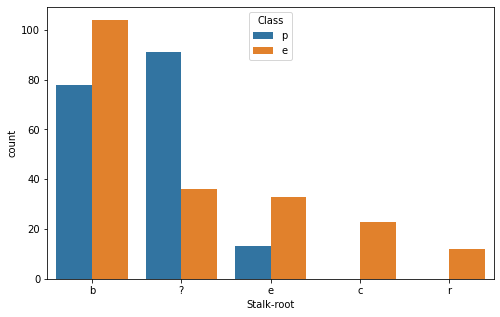

In [9]:
# for feature 'Stalk-root'
print(X_pre['Stalk-root'].value_counts()/len(X_pre))

plt.figure(figsize=(8,5))
sns.countplot(data=X_pre_l,x='Stalk-root',hue=y_pre_l)
plt.show()

### Dependence

In [10]:
# compute variable vs variable chi2 test of independence
pvals = {}
for col in cols[:-1]:
    ls = []
    for c in cols[:-1]:
        oe = OrdinalEncoder()
        temp = oe.fit_transform(X_pre[[col,c]])
        ls += [chi2(temp[:,0].reshape(-1, 1),temp[:,1].reshape(-1, 1))[1][0]]
    pvals[col] = np.round(ls,3)

# show the maximum p-value for each attribute
pd.DataFrame(pvals).max()

Cap-shape                   0.611
Cap-surface                 0.681
Cap-color                   0.597
Bruises                     0.146
Odor                        0.865
Gill-attachment             0.957
Gill-spacing                0.017
Gill-size                   0.003
Gill-color                  0.000
Stalk-shape                 0.784
Stalk-root                  0.000
Stalk-surface-above-ring    0.912
Stalk-surface-below-ring    0.988
Stalk-color-above-ring      0.217
Stalk-color-below-ring      0.160
Veil-type                     NaN
Veil-color                  0.992
Ring-number                 0.979
Ring-type                   0.007
Spore-print-color           0.778
Population                  0.056
Habitat                     0.111
dtype: float64

# Feature Engineering

### Combine Values & Feature Selection

using results from pretraining set

In [11]:
# 'Odor': {a,l}, {c,f,m,p,s,y}
# 'Stalk-color-above-ring': {e,g,o},{b,c,n}
# 'Stalk-color-below-ring': {e,g,o},{b,c,n}
# 'Ring-type': {},{l,n}

def preprocess(X):
    # drop attributes
    dropped = ['Veil-type','Stalk-root','Gill-color']
    X = X.drop(dropped,axis=1)
    
    # combine values
    X['Odor'] = X['Odor'].replace(['a','l'],['1','1'])
    X['Odor'] = X['Odor'].replace('c,f,m,p,s,y'.split(','),['2']*6)
    X['Stalk-color-above-ring'] = X['Stalk-color-above-ring'].replace(['e','g','o'],['1','1','1'])
    X['Stalk-color-above-ring'] = X['Stalk-color-above-ring'].replace(['b','c','n'],['2','2','2'])
    X['Stalk-color-below-ring'] = X['Stalk-color-below-ring'].replace(['e','g','o'],['1','1','1'])
    X['Stalk-color-below-ring'] = X['Stalk-color-below-ring'].replace(['b','c','n'],['2','2','2'])
    X['Ring-type'] = X['Ring-type'].replace(['l','n'],['1','1'])
    
    return X

In [12]:
# convert the data to numeric values
oe = OrdinalEncoder()
oe.fit(preprocess(X_train))
X_temp_l = oe.transform(preprocess(X_pre_l))

# select top 15 features using chi2
selector = SelectKBest(chi2,k=15)
selector.fit(X_temp_l,y_pre_l)

feats = np.setdiff1d(cols,['Veil-type','Stalk-root','Gill-color','Class'])
feats = selector.get_feature_names_out(feats)
feats

array(['Bruises', 'Cap-color', 'Cap-surface', 'Gill-attachment',
       'Gill-spacing', 'Habitat', 'Odor', 'Population', 'Ring-number',
       'Spore-print-color', 'Stalk-color-below-ring', 'Stalk-shape',
       'Stalk-surface-above-ring', 'Stalk-surface-below-ring',
       'Veil-color'], dtype=object)

### PCA

using training set

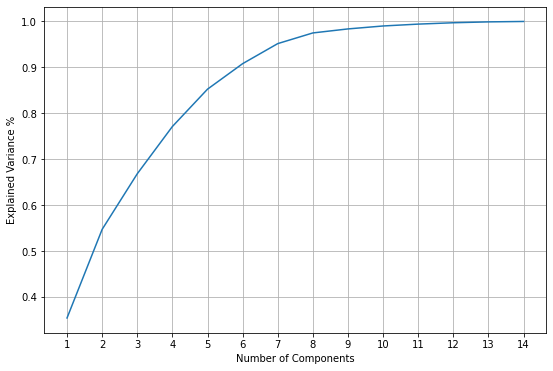

In [13]:
# fit PCA on the training set
X_ = X_train[feats]
X_ = OrdinalEncoder().fit_transform(X_)

var = []
ks = np.arange(1,len(feats))
for k in ks:
    pca = PCA(n_components=k)
    pca.fit(X_)
    var += [sum(pca.explained_variance_ratio_)]
    
# plot # of components vs. var.
plt.figure(figsize=(9,6))
plt.plot(range(1,len(feats)),var)
plt.xticks(ks), plt.xlabel('Number of Components'), plt.ylabel('Explained Variance %')
plt.grid()
plt.show()

### Combine All Steps

In [14]:
def FeatEng(Xtrain,ytrain,Xtest,ytest):
    Xtrain = preprocess(Xtrain)[feats]
    Xtest = preprocess(Xtest)[feats]
    
    oe = OrdinalEncoder()
    oe.fit(Xtrain)
    Xtrain = oe.transform(Xtrain)
    Xtest = oe.transform(Xtest)
    
    pca = PCA(n_components=8)
    pca.fit(Xtrain)
    Xtrain = pca.transform(Xtrain)
    Xtest = pca.transform(Xtest)
    
    le = LabelEncoder()
    le.fit(ytrain)
    ytrain = le.transform(ytrain)
    ytest = le.transform(ytest)
    
    return Xtrain,ytrain,Xtest,ytest

In [15]:
# feature engineering on data
X_train, y_train, X_test, y_test = FeatEng(X_train, y_train, X_test, y_test)

# unlabel data, convert to SSL dataset
# for SL methods
X_train_l, X_train_u, y_train_l, y_train_u = train_test_split(X_train,y_train,test_size=0.7,random_state=1)
# for SSL methods
X_train_ssl = np.concatenate((X_train_l,X_train_u))
y_train_ssl = np.concatenate((y_train_l,np.full(y_train_u.shape,-1)))

# Model Training

In [16]:
# function for evaluating the SL models
# score function: f1-score
def cross_val_sl(X,y,clf):
    scores = cross_validate(clf,X,y,scoring='f1')
    print('avg. of val scores: {}'.format(round(np.mean(scores['test_score']),3)))
    print('std. of val scores: {}'.format(round(np.std(scores['test_score']),3)))
    return (scores['test_score'])

# function for evaluating the SSL by using KFold (k=5)
# score function: f1-score
def cross_val_ssl(X,y,clf):
    scores = []
    kfold = KFold(n_splits=5,shuffle=True,random_state=1)
    for train_idx, test_idx in kfold.split(X,y):
        clf.fit(X[train_idx],y[train_idx])
        val_idx = y[test_idx] != -1
        pred = clf.predict(X[test_idx][val_idx])
        scores += [f1_score(pred,y[test_idx][val_idx])]
    print('avg. of val scores: {}'.format(round(np.mean(scores),3)))
    print('std. of val scores: {}'.format(round(np.std(scores),3)))
    return (scores)

### Supervised Leaning - Baseline

In [17]:
# baseline trivial (predict based on prob. of train)
clf_dum = DummyClassifier(strategy='stratified',random_state=2)
cross_val_sl(X_train_l,y_train_l,clf_dum)
clf_dum.fit(X_train_l,y_train_l)

avg. of val scores: 0.454
std. of val scores: 0.03


DummyClassifier(random_state=2, strategy='stratified')

In [18]:
# baseline non-trivial (logistic regression)
clf_log = LogisticRegression(random_state=0)
cross_val_sl(X_train_l,y_train_l,clf_log)
clf_log.fit(X_train_l,y_train_l)

avg. of val scores: 0.872
std. of val scores: 0.021


LogisticRegression(random_state=0)

### Supervised Learning - Decision Tree

max_depth=1
avg. of val scores: 0.82
std. of val scores: 0.015
max_depth=2
avg. of val scores: 0.881
std. of val scores: 0.016
max_depth=3
avg. of val scores: 0.922
std. of val scores: 0.015
max_depth=4
avg. of val scores: 0.947
std. of val scores: 0.01
max_depth=5
avg. of val scores: 0.952
std. of val scores: 0.012


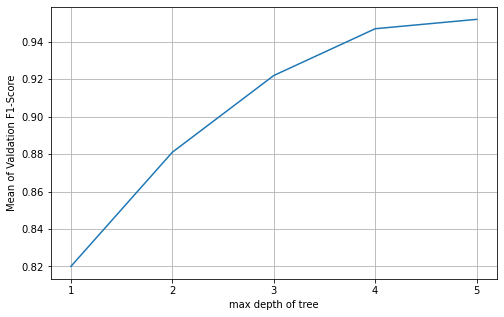

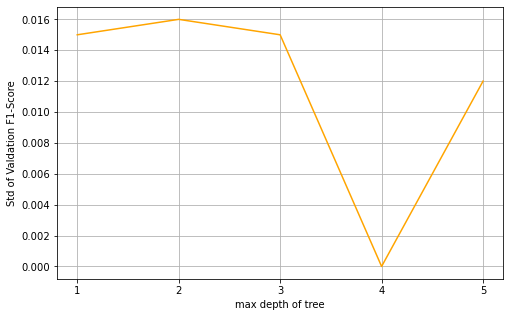

In [19]:
# hyper-param. tuning for decision tree
for d in range(1,6):
    print('max_depth={}'.format(d))
    clf = DecisionTreeClassifier(max_depth=d,random_state=24)
    cross_val_sl(X_train_l,y_train_l,clf)

# plot the validation scores
d = np.arange(1,6)

plt.figure(figsize=(8,5))
plt.plot(d, [0.82,0.881,0.922,0.947,0.952])
plt.xticks(d),plt.grid()
plt.xlabel('max depth of tree'), plt.ylabel('Mean of Valdation F1-Score')
plt.show()

plt.figure(figsize=(8,5))
plt.plot(d, [0.015,0.016,0.015,0.0,0.012],color='orange')
plt.xlabel('max depth of tree'), plt.ylabel('Std of Valdation F1-Score')
plt.xticks(d),plt.grid()
plt.show()

In [20]:
# decision tree classifier
clf_tree = DecisionTreeClassifier(max_depth=4,random_state=10)
cross_val_sl(X_train_l,y_train_l,clf_tree)
clf_tree.fit(X_train_l,y_train_l)

avg. of val scores: 0.946
std. of val scores: 0.01


DecisionTreeClassifier(max_depth=4, random_state=10)

### Supervised Learning - Linear SVM

In [21]:
# linear SVM classifier

# hyper-param. tuning for SVM
for c in [0.01,0.05,0.1,0.5,1]:
    print('lambda={}'.format(c))
    clf = SVC(kernel='linear',C=c)
    cross_val_sl(X_train_l,y_train_l,clf)

print()
clf_svm = SVC(kernel='linear',random_state=10)
cross_val_sl(X_train_l,y_train_l,clf_svm)
clf_svm.fit(X_train_l,y_train_l)

lambda=0.01
avg. of val scores: 0.872
std. of val scores: 0.016
lambda=0.05
avg. of val scores: 0.882
std. of val scores: 0.017
lambda=0.1
avg. of val scores: 0.885
std. of val scores: 0.014
lambda=0.5
avg. of val scores: 0.887
std. of val scores: 0.017
lambda=1
avg. of val scores: 0.889
std. of val scores: 0.015

avg. of val scores: 0.889
std. of val scores: 0.015


SVC(kernel='linear', random_state=10)

### Semi-Supervised Learning - Self-Training

In [22]:
# self-training model
clf_self = SelfTrainingClassifier(base_estimator=DecisionTreeClassifier(max_depth=4,random_state=24),max_iter=1000)
cross_val_ssl(X_train_ssl,y_train_ssl,clf_self)
clf_self.fit(X_train_ssl,y_train_ssl)

avg. of val scores: 0.937
std. of val scores: 0.012


SelfTrainingClassifier(base_estimator=DecisionTreeClassifier(max_depth=4,
                                                             random_state=24),
                       max_iter=1000)

### Semi-Supervised Learning - S3VM

Traning Scores with lambda = 0.01: 0.8757637474541752
Traning Scores with lambda = 0.05: 0.8677740863787375
Traning Scores with lambda = 0.1: 0.86264100862641
Traning Scores with lambda = 0.5: 0.6939058171745154
Traning Scores with lambda = 1: 0.6852861035422343


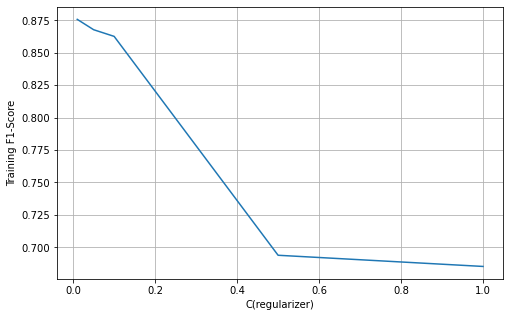

In [23]:
# provided by NekoYIQI's Github Repo.
# https://github.com/NekoYIQI/QNS3VM

warnings.filterwarnings('ignore')
# convert {0,1} to {-1,1}
y_trtemp_l = y_train_l.copy()
y_trtemp_l[y_trtemp_l==0] = -1

# random generator
myRandom = random.Random()
myRandom.seed(0)

scores = []
for l in [0.01,0.05,0.1,0.5,1]:
    # train model
    clf = QN_S3VM(X_l=X_train_l.tolist(),L_l=y_trtemp_l.tolist(),
                       X_u=X_train_u.tolist(),random_generator=myRandom,kernel_type='Linear',lam=l)
    clf.train()
    pred = clf.getPredictions(X=X_train_l)
    score = f1_score(pred,y_trtemp_l)
    print("Traning Scores with lambda = {}: {}".format(l,score))
    
    scores += [score]

plt.figure(figsize=(8,5))
plt.plot([0.01,0.05,0.1,0.5,1], scores)
plt.grid()
plt.xlabel('C(regularizer)'), plt.ylabel('Training F1-Score')
plt.show()

clf_s3vm = QN_S3VM(X_l=X_train_l.tolist(),L_l=y_trtemp_l.tolist(),
                   X_u=X_train_u.tolist(),random_generator=myRandom,kernel_type='Linear',lam=0.05)

### Semi-Supervised Learning - Label Propagation (Harmonic Function)

In [24]:
# label propagation
clf_har_1 = LabelPropagation(kernel='knn')
cross_val_ssl(X_train_ssl,y_train_ssl,clf_har_1)

clf_har_2 = LabelPropagation(kernel='rbf')
cross_val_ssl(X_train_ssl,y_train_ssl,clf_har_2)

clf_har = LabelPropagation(kernel='rbf')
clf_har.fit(X_train_ssl,y_train_ssl)

avg. of val scores: 0.96
std. of val scores: 0.011
avg. of val scores: 0.993
std. of val scores: 0.007


LabelPropagation()

# Model Evaluation

In [25]:
# baselines
print(f1_score(clf_dum.predict(X_test),y_test))
print(f1_score(clf_log.predict(X_test),y_test))

0.4797947402180885
0.8533668974197608


In [26]:
# SL
f1_score(clf_tree.predict(X_test),y_test)

0.9493506493506493

In [27]:
# SSL
f1_score(clf_har.predict(X_test),y_test)

0.9862155388471179